# Behavrioal Cloning Project #

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

Links: 
* Simulators: [macOS](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f290_simulator-macos/simulator-macos.zip), [Windows 64-bit](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f3a4_simulator-windows-64/simulator-windows-64.zip), [Linux](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f0f7_simulator-linux/simulator-linux.zip)




## 1. Data Collecting

In this project, three kinds of data are collected according to different strategies respectively. They are placed in three folders: data_stable, data_left and data_right.

### Strategies for collecting 'stable' data.

* the collected data will be all saved in the folder named 'data_stable'
* the car should stay in the center of the road as much as possible
* if the car veers off to the side, it should recover back to center
* driving both clockwise and counter-clockwise on the track one for two laps each
* driving both clockwise and counter-clockwise on the second track for one lap each

### Strategies for collecting 'right-turn' data

* the collected data will be all saved in the folder named 'data_right'
* the car will be drove to the left side of road on purpose, then steer back to the middle 
* repeat the above step in driving
* driving both clockwise and counter-clockwise on the track one for two laps each

### Strategies for collecting 'left-turn' data

* the collected data will be all saved in the folder named 'data_left'
* the car will be drove to the right side of road on purpose, then steer back to the middle 
* repeat the above step in driving
* driving both clockwise and counter-clockwise on the track one for two laps each


In [1]:
import os

for file_or_folder in os.listdir():
    if file_or_folder != '.DS_Store' and file_or_folder != '.ipynb_checkpoints':
        print(file_or_folder)


data_left
data_right
data_stable
Default Mac desktop Universal.app
drive.py
model.ipynb


## 2. Tidying the Data and Exploratory Analysis

### Data Set: data_stable

* all images are collected 
* flip images in data_stable whose steering measurements are out of the range (-0.05, 0.05).
* the flipped images and steering measurements will be also collected 

  Notes. the largest steering angle of a car in the simulator is 25 degree, while the largest measurement is adjusted to 1. The ratio is 1 degree to a value 0.04.
  
### Data Set: data_right

* only images whose steering measurements are among (0.45, 0.9) are collected
* flip the collected images and steering measurements and add them to the collected data

### Data Set: data_left

* only images whose steering measurements are among (-0.9, -0.45) are collected
* flip the collected images and steering measurements and add them to the collected data



In [2]:
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Data collecting and tidying
samples_stable = []
samples_left   = []
samples_right  = []

# data_stable

with open('./data_stable/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        image_dir = line[0]
        steering_angle = float(line[3])
        if -0.05 < steering_angle < 0.05:
            samples_stable.append([0, image_dir, steering_angle])
        else:
            samples_stable.append([0, image_dir, steering_angle])
            samples_stable.append([1, image_dir, -steering_angle])

# data_right

with open('./data_right/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if 0.45 < float(line[3]) < 0.9:
            image_dir = line[0]
            steering_angle = float(line[3])
            samples_right.append([0, image_dir, steering_angle])
            samples_right.append([1, image_dir, -steering_angle])

# data_left

with open('./data_left/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if -0.9 < float(line[3]) < -0.45:
            image_dir = line[0]
            steering_angle = float(line[3])
            samples_left.append([0, image_dir, steering_angle])
            samples_left.append([1, image_dir, -steering_angle])
            
samples_stable.extend(samples_left)
samples_stable.extend(samples_right)

# data collecting
samples = samples_stable

The list 'samples' is the data that will be used in training and validation. It's structure is as follows.

* samples[i][0]: integer value, 1 or 0 
  - 1 means needs to flip
  - 0 means no needs to flip

* samples[i][1]: str value, record a image directory

* samples[i][2]: float, steering measurements
  It already records a correct value. No needs to change its sign.

In [4]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

### Data Visualization

Number of samples: 8974


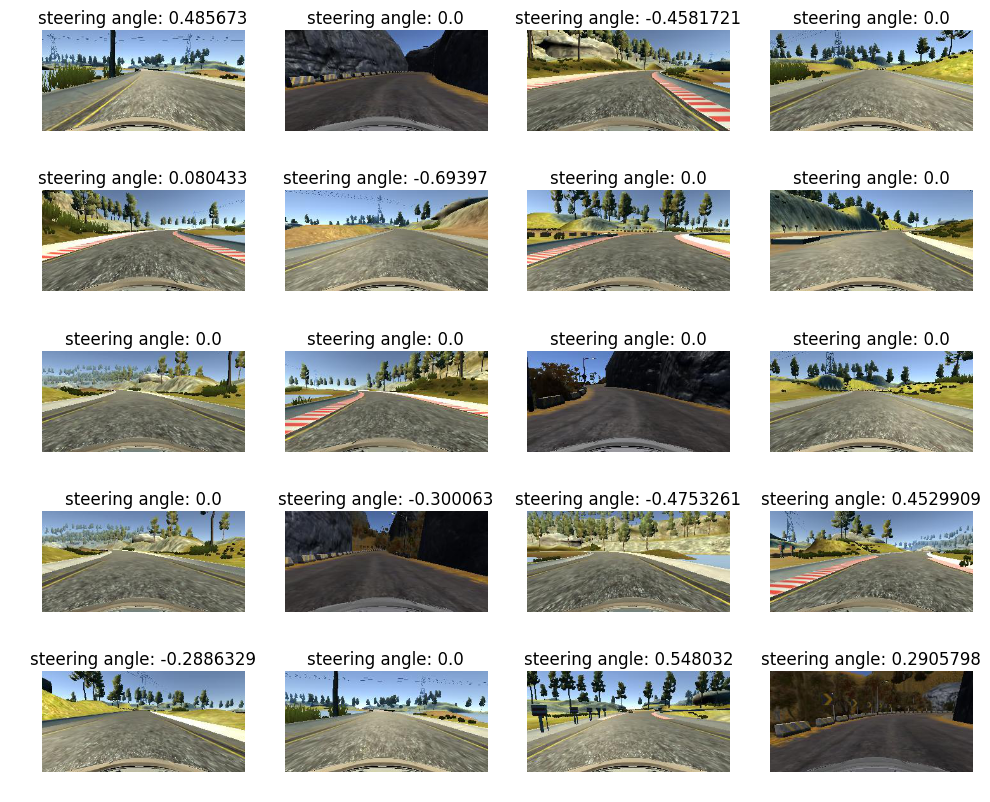

In [5]:
# Data Visualization

l = len(samples)
print("Number of samples: {}".format(l))

indexes = np.random.choice(range(l), 20)
steerings_v = []
images_v    = []
for index in indexes:
    steerings_v.append(samples[index][2])
    if samples[index][0]:
        images_v.append(np.fliplr(plt.imread(samples[index][1])))
    else:
        images_v.append(plt.imread(samples[index][1]))
plt.figure(figsize=(12,10))
for i in range(len(indexes)):
    plt.subplot(5,4,i+1)
    plt.imshow(images_v[i])
    plt.title("steering angle: {}".format(steerings_v[i]))
    plt.axis("off")
    

(0, 200)

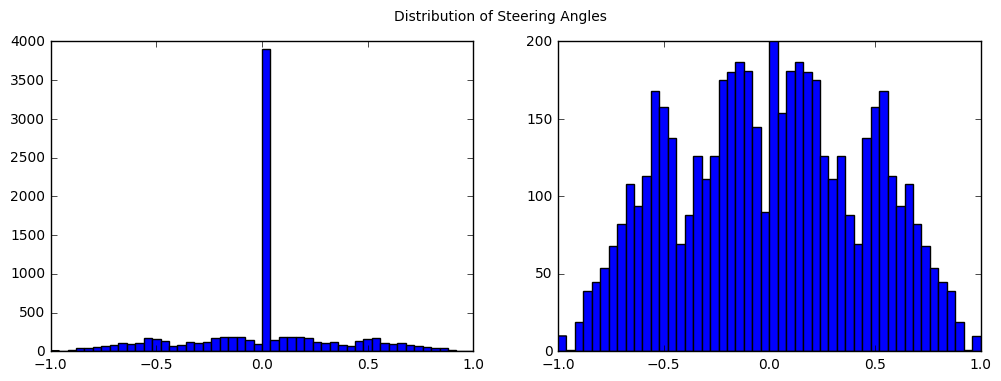

In [6]:
# Data Visualization: distribution of steering angles

steering_angles = []
for i in range(l):
    steering_angles.append(samples[i][2])
plt.figure(figsize=(12,4))
plt.suptitle("Distribution of Steering Angles")
plt.subplot(1,2,1)
plt.hist(steering_angles, bins=50)
plt.subplot(1,2,2)
plt.hist(steering_angles, bins=50)
plt.ylim((0,200))


## 3. Modeling 

### Images Preprocess and Generator

* As a first try, a model similar to [nvidia architecture](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) is used in this project. So all images should be resized to a shape (66,200,3).

* I was intended to combine all image preprocessing steps, such as cropping, resizing and normalization, into the model architecture. But I failed because error occurs when a Cropping2D layer is added into the model. Instead, the cropping step is moved to the generator.

* Observe that at least the upper 1/3 of images contain no road information. And the bottom 20 pixels are mostly hood of the car. Hence, these two parts will be cropped. 

In [7]:
def crop_image(image):
    return image[60:140,:,:]

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[1]
                if batch_sample[0]:
                    center_image = cv2.flip(cv2.imread(name), 1)
                else:
                    center_image = cv2.imread(name)
                # trim image to only see section with road
                center_image = crop_image(center_image)
                center_angle = batch_sample[2]
                images.append(center_image)
                angles.append(center_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


In [8]:
from keras.models import Sequential, Model
from keras.layers import Lambda, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D
import tensorflow as tf

def resize_image(image, new_size=(66, 200)):
    return tf.image.resize_images(image, size=new_size, method=3, align_corners=False)

drop_prob = 0.5

model = Sequential()
# Preprocess incoming data, resize image to fit navidia architecture
model.add(Lambda(resize_image, input_shape=(80,320,3), output_shape=(66,200,3)))
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dropout(drop_prob))
model.add(Dense(512,activation='relu'))
model.add(Dropout(drop_prob))
model.add(Dense(128,activation='relu'))
model.add(Dense(1))
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [9]:
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_samples), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                    nb_epoch=4)

Epoch 1/4
7179/7179 [==============================] - 117s - loss: 0.0569 - val_loss: 0.0407
Epoch 2/4
7179/7179 [==============================] - 106s - loss: 0.0447 - val_loss: 0.0417
Epoch 3/4
7179/7179 [==============================] - 118s - loss: 0.0410 - val_loss: 0.0368
Epoch 4/4
7179/7179 [==============================] - 115s - loss: 0.0387 - val_loss: 0.0375


In [10]:
## save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk
